In [1]:
w_python = !which python
if 'home' in w_python[0]:
    resources_prefix = ''
else:
    !pip install watermark

    from google.colab import drive
    drive.mount('/content/drive')

    resources_prefix = '/content/drive/MyDrive/Machine Learning/Notebooks/0603_Vision - Image Compression/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !conda install -y watermark

In [3]:
%load_ext watermark
%watermark

Last updated: 2022-08-05T20:22:18.255218+00:00

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.188+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



In [4]:
from sklearn.datasets import fetch_lfw_people

import matplotlib.pyplot as plt

from scipy.linalg import svd

import numpy as np

from ipywidgets import IntSlider, interact

# Resume

SVD puede ser utilizado para comprimir imágenes, extrayendo aquellos componentes que son fundamentales a la hora de representar lo que hay en las imágenes y eliminando el resto (el ruido).

Para este ejemplo vamos a usar el dataset [Labeled Faces in the Wild (LFW)](http://vis-www.cs.umass.edu/lfw/) que contiene un conjunto de imágenes de personajes famosos enfocado al reconocimiento facial (y que es un dataset desarrollado por la universidad donde hice mi proyecto final de carrera, **let's go UMASS!**)

El dataset consiste de 3020 imágenes de famosos (los famosos aparecen múltiples veces). La variable objetivo es el nombre del famoso.

Las imágenes son básicamente arrays de numeros donde cuanto mayor sea el número más claro es el píxel (son imágenes de tamaño 87 pixeles de anchura por 65 de altura).

# Data Collection

https://www.udemy.com/course/aprende-data-science-y-machine-learning-con-python/learn/lecture/8309620#overview

In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=50, resize=1)
lfw_people

{'DESCR': ".. _labeled_faces_in_the_wild_dataset:\n\nThe Labeled Faces in the Wild face recognition dataset\n------------------------------------------------------\n\nThis dataset is a collection of JPEG pictures of famous people collected\nover the internet, all details are available on the official website:\n\n    http://vis-www.cs.umass.edu/lfw/\n\nEach picture is centered on a single face. The typical task is called\nFace Verification: given a pair of two pictures, a binary classifier\nmust predict whether the two images are from the same person.\n\nAn alternative task, Face Recognition or Face Identification is:\ngiven the picture of the face of an unknown person, identify the name\nof the person by referring to a gallery of previously seen pictures of\nidentified persons.\n\nBoth Face Verification and Face Recognition are tasks that are typically\nperformed on the output of a model trained to perform Face Detection. The\nmost popular model for Face Detection is called Viola-Jones

Nombre de las personas

In [6]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Jacques Chirac',
       'Jean Chretien', 'John Ashcroft', 'Junichiro Koizumi',
       'Serena Williams', 'Tony Blair'], dtype='<U17')

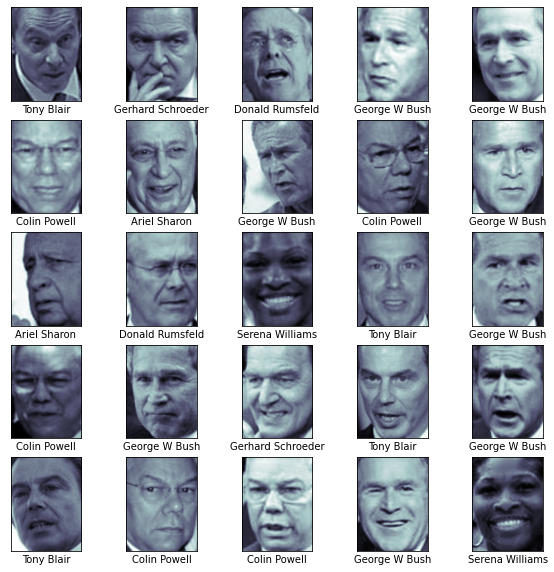

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)
fig, ax = plt.subplots(5, 5)

for i, axi in enumerate(ax.flat):
    axi.imshow(lfw_people.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[], xlabel=lfw_people.target_names[lfw_people.target[i]])

plt.show()

Mostrando una cara

In [8]:
def dibujar_cara(matriz_cara):
    plt.figure(figsize=(9,6))
    plt.imshow(matriz_cara, cmap='gray');

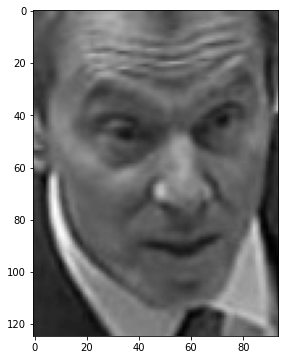

In [9]:
dibujar_cara(lfw_people.images[0])

Tamaño de la imagen en KB

In [10]:
def kb_totales(*arrays):
    return sum(map(lambda a: a.nbytes, arrays)) / 1024

In [11]:
kb_totales(lfw_people.images[0])

45.8984375

# Processing

Para hacer una descomposición SVD completa podemos usar el método [`scipy.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd).

In [12]:
U, s, V = svd(lfw_people.images[0], full_matrices=True)
U.shape, s.shape, V.shape

((125, 125), (94,), (94, 94))

Vemos que el método svd no devuelve la matriz de valores singulares Sigma como matriz, sino como vector (el resto de elementos son 0). La convertimos a una matriz diagonal de tamaño $87\times65$.

In [13]:
S = np.zeros((U.shape[0], V.shape[0]))
S[:V.shape[0], :V.shape[0]] = np.diag(s)
S.shape

(125, 94)

In [14]:
S

array([[10880.54296875,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  1833.3927002 ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  1384.26708984, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

Podemos recomponer la imagen original haciendo el producto de las matrices U, S y V.

In [15]:
cara_svd = U @ S @ V

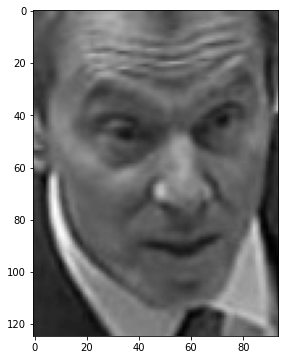

In [16]:
dibujar_cara(lfw_people.images[0])

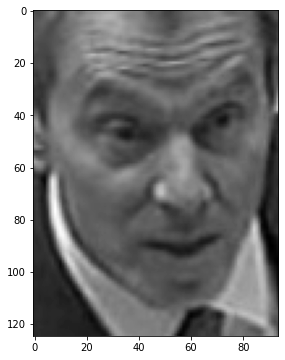

In [17]:
dibujar_cara(cara_svd)

In [18]:
kb_totales(U, s, V)

95.91796875

Vemos que las matrices factores de la imagen ocupan más tamaño que la imagen original (47 kb versus 22 kb). Sin embargo, hemos realizado una descomposición total (**Full SVD**).

Se puede descomponer usando un número específico de valroes singulares **K** que sea menor que d y utilizarlos para recomponer la imagen a costa de perder algo de información.

In [19]:
@interact(img_pos=IntSlider(10, min=0, max=lfw_people.target.size - 1), k=IntSlider(65, min=1, max=65))
def evaluar_k_imagen(img_pos, k):
    Ux, sx, Vx = np.linalg.svd(lfw_people.images[img_pos], full_matrices=True)

    U_k = Ux[:, :k]
    s_k = sx[:k]
    V_k = Vx[:k, :]

    memoria_real = kb_totales(lfw_people.images[img_pos])
    memoria_k = kb_totales(U_k, s_k, V_k)

    # Calculamos la reduccion en tamaño respecto a la imagen original
    pct_reduccion = 100 * (1 - (memoria_k / memoria_real))
    imagen_k_svd = U_k @ np.diag(s_k) @ V_k
    dibujar_cara(imagen_k_svd)
    
    target = lfw_people.target[img_pos]
    target_name = lfw_people.target_names[target]

    plt.title("{} valores singulares, tamaño real: {:.1f} kb, tamaño: {:.1f} kb ({:.1f}% menor), target name: {}".format(k, memoria_real, memoria_k, 
                                                                                                                         pct_reduccion, target_name), size=20)

    plt.show()

interactive(children=(IntSlider(value=10, description='img_pos', max=1559), IntSlider(value=65, description='k…